In [1]:
!pip install -U scikit-survival

     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.17.1-cp37-cp37m-linux_x86_64.whl size=4088268 sha256=2982aa10587122c988b9aec7da3b6ed191b0d1931ed8972c95fef107c12adc35
  Stored in directory: /root/.cache/pip/wheels/78/43/46/b5c9ba2d44e7e5de3d321c76bbff4e5480cd69d486b38d359f
Successfully built scikit-survival


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [3]:
pip install lifelines

     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=9c4dd5120b396a3120c547d53eb6da51f686a5b3ca5cfaf1dc551c81a2ba27b9
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [4]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving 0227_optimal_target_snuh.csv to 0227_optimal_target_snuh.csv
Saving 0227_X_NaN_snuh.csv to 0227_X_NaN_snuh.csv
Saving 0227_X_y_imputed_whole.csv to 0227_X_y_imputed_whole.csv


In [5]:
import io
optimal_snuh = pd.read_csv(io.BytesIO(uploaded['0227_optimal_target_snuh.csv'])) 
X_with_nans_snuh = pd.read_csv(io.BytesIO(uploaded['0227_X_NaN_snuh.csv']))
proact_train_set = pd.read_csv(io.BytesIO(uploaded['0227_X_y_imputed_whole.csv'])) 

In [6]:
optimal_snuh.drop('Unnamed: 0', axis = 1, inplace = True)
X_with_nans_snuh.drop('Unnamed: 0', axis = 1, inplace = True)
proact_train_set.drop('Unnamed: 0', axis = 1, inplace = True)

# 1. Missing data proportion

In [7]:
def report_nulls(df):
    '''
    Show a fast report of the DF.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    null_cols = 0
    list_of_nulls_cols = []
    list_of_nulls_cols_pcn = []
    list_of_nulls_cols_over60 = []
    for col in list(df.columns):
        null_values_rows = df[col].isnull().sum()
        null_rows_pcn = round(((null_values_rows)/rows)*100, 2)
        col_type = df[col].dtype
        if null_values_rows > 0:
            print("The column {} has {} null values. It is {}% of total rows.".format(col, null_values_rows, null_rows_pcn))
            print("The column {} is of type {}.\n".format(col, col_type))
            null_cols += 1
            list_of_nulls_cols.append(col)
            list_of_nulls_cols_pcn.append(null_rows_pcn)
            if null_rows_pcn > 60:
                list_of_nulls_cols_over60.append(col)
    null_cols_pcn = round((null_cols/columns)*100, 2)
    print("The DataFrame has {} columns with null values. It is {}% of total columns.".format(null_cols, null_cols_pcn))
    plt.plot(list_of_nulls_cols, list_of_nulls_cols_pcn)
    return list_of_nulls_cols_over60

The column mean_fvc has 90 null values. It is 40.36% of total rows.
The column mean_fvc is of type float64.

The column mean_Creatinine has 99 null values. It is 44.39% of total rows.
The column mean_Creatinine is of type float64.

The column mean_weight has 5 null values. It is 2.24% of total rows.
The column mean_weight is of type float64.

The column slope_weight has 98 null values. It is 43.95% of total rows.
The column slope_weight is of type float64.

The column slope_ALSFRS_R_Total has 95 null values. It is 42.6% of total rows.
The column slope_ALSFRS_R_Total is of type float64.

The column slope_Q1_Speech has 95 null values. It is 42.6% of total rows.
The column slope_Q1_Speech is of type float64.

The column slope_Q2_Salivation has 95 null values. It is 42.6% of total rows.
The column slope_Q2_Salivation is of type float64.

The column slope_Q3_Swallowing has 95 null values. It is 42.6% of total rows.
The column slope_Q3_Swallowing is of type float64.

The column slope_Q4_Hand

[]

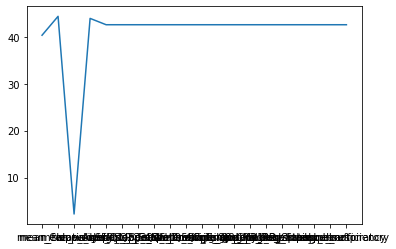

In [8]:
report_nulls(X_with_nans_snuh)

# 2. Check heterogeneity : Primary set(PROACT) vs Secondary set(SNUH)

###(1) Sample size

In [11]:
PA = proact_train_set.copy()
SNUH = X_with_nans_snuh.merge(optimal_snuh, on='SubjectID')

print("Train set of PROACT data has", len(PA), "patients")
print("Test set of SNUH registry data has", len(SNUH), "patients")

Train set of PROACT data has 2827 patients
Test set of SNUH registry data has 221 patients


###(2) Amount of censored data

In [12]:
event_distribution = pd.DataFrame(PA[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status_o', 'count']
event_distribution['status_o'] = event_distribution['status_o'].astype('bool')
event_distribution = event_distribution.replace({'status_o': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)

event_distribution_2 = pd.DataFrame(SNUH[['status_opt']].value_counts()).reset_index()
event_distribution_2.columns = ['status_o', 'count']
event_distribution_2['status_o'] = event_distribution_2['status_o'].astype('bool')
event_distribution_2 = event_distribution_2.replace({'status_o': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution_2)

A_1 = event_distribution.iloc[0]['count']
B_1 = event_distribution.iloc[1]['count']
per_0 = str(round((A_1/(A_1+B_1))*100,2))+"%"
per_1 = str(round((B_1/(A_1+B_1))*100,2))+'%'

A = event_distribution_2.iloc[0]['count']
B = event_distribution_2.iloc[1]['count']
perc_0 = str(round((A/(A+B))*100,2))+"%"
perc_1 = str(round((B/(A+B))*100,2))+'%'

       status_o  count
0  0 (censored)   2198
1   1 (occured)    629
       status_o  count
0  0 (censored)    194
1   1 (occured)     27


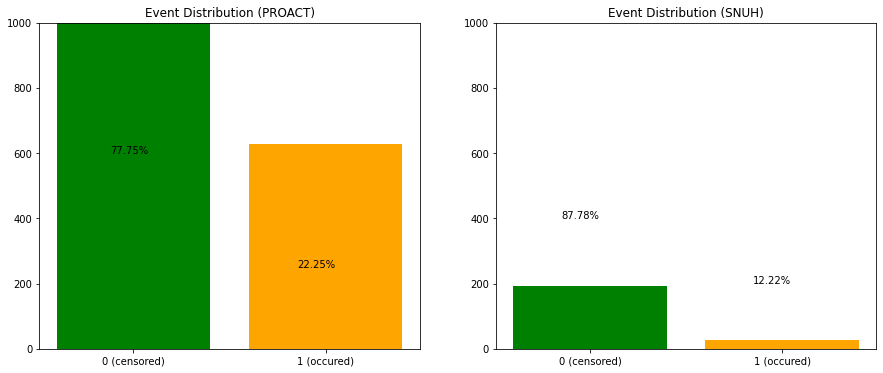

In [13]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.bar(event_distribution['status_o'], height=event_distribution['count'], color=['green', 'orange'])
plt.ylim([0,1000])
plt.title('Event Distribution (PROACT)')
plt.text(-0.12,600,per_0)
plt.text(0.85,250,per_1)

plt.subplot(122)
plt.bar(event_distribution_2['status_o'], height=event_distribution_2['count'], color=['green', 'orange'])
plt.ylim([0,1000])
plt.title('Event Distribution (SNUH)')
plt.text(-0.15,400,perc_0)
plt.text(0.85,200,perc_1)

plt.show()


### (3) follow-up time

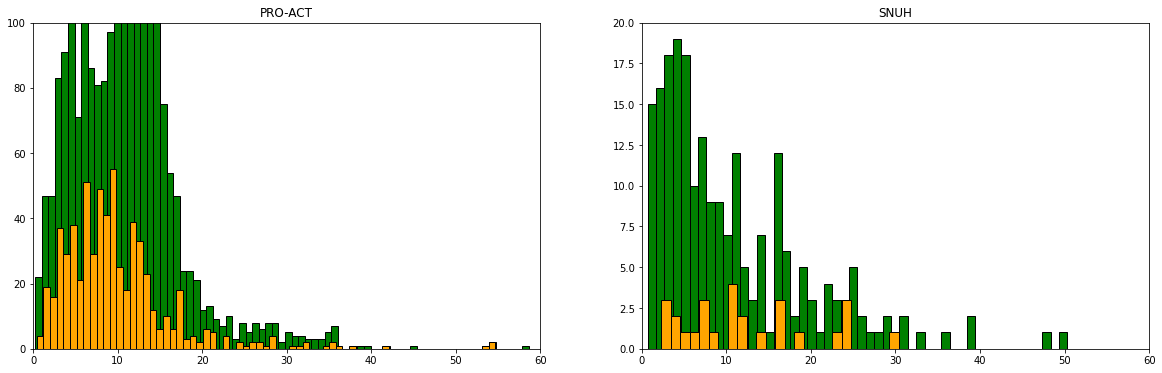

In [14]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
A = plt.hist(PA['time_opt'], color='green', bins=89, edgecolor='k', label='Censored + Uncensored')
A2 = plt.hist(PA[PA['status_opt']==1]['time_opt'], color='orange', alpha=1, bins=80,edgecolor='k', label='Censored')
plt.xlim([0,60])
plt.ylim([0,100])
plt.title('PRO-ACT')

plt.subplot(122)
plt.hist(SNUH['time_opt'], color='green', bins=50,edgecolor='k', label='Censored + Uncensored')
plt.hist(SNUH[SNUH['status_opt']==1]['time_opt'], color='orange', alpha=1, bins=25,edgecolor='k', label='Censored')
plt.xlim([0,60])
plt.ylim([0,20])
plt.title('SNUH')

plt.show()

###(4) KM estimation on event target

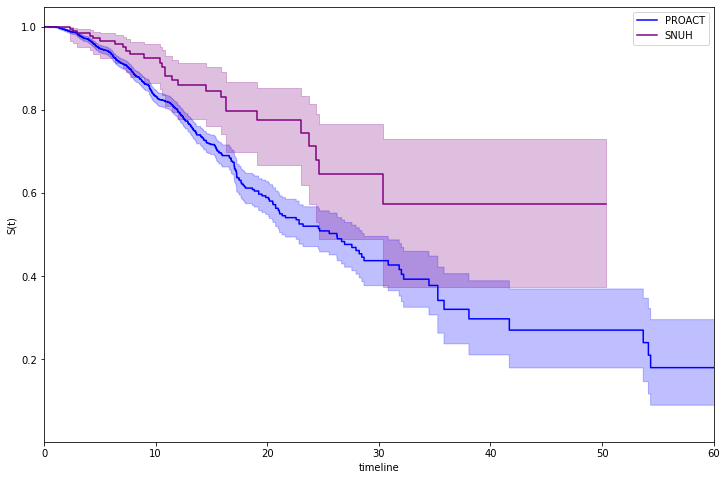

In [15]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

plt.figure(figsize=(12, 8))


PROACT = kmf.fit(PA["time_opt"], PA["status_opt"], label='PROACT')
ax_kmf = PROACT.plot(color='blue')
plt.xlim([0,60])

SNUh = kmf.fit(SNUH['time_opt'], SNUH['status_opt'], label='SNUH')
ax_kmf2 = SNUh.plot(color='purple')
plt.xlim([0,60])

plt.xlabel('timeline')
plt.ylabel('S(t)')
plt.show()

In [16]:
from lifelines.statistics import logrank_test
logrank_test(PA["time_opt"], SNUH["time_opt"], PA["status_opt"], SNUH["status_opt"]).p_value

0.0010887668446346184

# 3. Evaluation

###(1) Fitting on train set

In [17]:
df_train = proact_train_set.copy()

In [18]:
aft_feature_list = ['Age',  'diag_delta', 'onset_delta', 'onset_site', 'mean_fvc', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_respiratory', 'slope_ALSFRS_R_Total', 'slope_bulbar', 'slope_respiratory'] # 12 features

cph_feature_list = ['Age',  'diag_delta', 'onset_delta', 'onset_site', 'mean_fvc', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'slope_ALSFRS_R_Total', 'slope_bulbar'] # 10 features

rsf_feature_list = ['Age', 'onset_delta', 'onset_site', 'mean_fvc', 'slope_weight', 'mean_ALSFRS_R_Total', 'mean_bulbar', 'mean_motor','slope_ALSFRS_R_Total', 'slope_bulbar'] # 10 features

In [19]:
from sksurv.ensemble import RandomSurvivalForest
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_train[['status_opt', 'time_opt']]
df_train_rsf = df_train_rsf.replace({'status_opt':dic})
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 13.18), ( True,  9.44), (False,  5.06), ...,
       (False, 12.82), (False,  6.05), (False,  4.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [20]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01, l1_ratio = 1)
aft.fit(df_train[aft_feature_list+['time_opt', 'status_opt']], duration_col='time_opt', event_col='status_opt', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 2827 total observations, 2198 right-censored observations>

In [21]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio = 1)
cph.fit(df_train[cph_feature_list+['time_opt', 'status_opt']], 'time_opt', event_col='status_opt')

<lifelines.CoxPHFitter: fitted with 2827 total observations, 2198 right-censored observations>

In [22]:
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=8,  min_samples_leaf=14, max_features="auto",
                           n_jobs=-1, random_state=20)
rsf.fit(df_train[rsf_feature_list], y_train_rsf)

RandomSurvivalForest(min_samples_leaf=14, min_samples_split=8, n_jobs=-1,
                     random_state=20)

In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(sample_posterior = True, random_state=11)

df_full_slope_X = df_full_slope.drop(['time_opt', 'status_opt'], axis = 1)
ar1 = imputer.fit_transform(df_full_slope_X)
df_full_slope_X_imputed = pd.DataFrame(ar1, columns = df_full_slope_X.columns)
df_full_slope_imputed = pd.merge(df_full_slope_X_imputed, optimal_snuh, on = 'SubjectID')



In [43]:
df_full_slope_imputed

,SubjectID,Gender,Age,onset_site,onset_delta,diag_delta,diag_minus_onset,mean_fvc,mean_Creatinine,mean_weight,...,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_R1_Dyspnea,slope_R2_Orthopnea,slope_R3_Respiratory_Insufficiency,slope_bulbar,slope_motor,slope_respiratory,time_opt,status_opt
0,1005.0,1.0,3.0,0.0,-4.504110,-1.545205,2.958904,77.000000,80.666667,69.000000,...,-0.113414,-0.142440,-0.079108,-0.051693,-0.014993,-0.143194,-0.801508,-0.147702,30.378082,1
1,1017.0,0.0,11.0,1.0,-6.739726,-0.756164,5.983562,46.500000,62.000000,51.500000,...,-0.460859,0.460859,-1.382576,-0.460859,0.000000,-0.460859,1.843434,-1.843434,3.024658,0
2,1019.0,0.0,9.0,0.0,-16.767123,-4.734247,12.032877,77.000000,77.766380,56.000000,...,0.000000,-0.334249,0.000000,0.000000,0.000000,-0.334249,-0.668498,0.000000,20.515068,0
3,1020.0,0.0,8.0,0.0,-21.863014,-0.821918,21.041096,75.000000,60.194248,47.500000,...,-0.683521,-0.341760,-0.683521,0.000000,0.000000,0.000000,-2.734082,-0.683521,2.926027,0
4,1021.0,0.0,5.0,0.0,-25.906849,-0.854795,25.052055,104.405684,52.000000,75.000000,...,-0.103708,-0.143633,-0.081092,-0.054633,-0.025560,-0.141611,-0.799260,-0.162529,47.769863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,1654.0,1.0,7.0,0.0,-8.909589,-3.879452,5.030137,88.884164,64.911773,62.000000,...,-0.103778,-0.148395,-0.080551,-0.053177,-0.024501,-0.138250,-0.800918,-0.157180,3.221918,0
217,1655.0,1.0,8.0,1.0,-12.164384,-1.183562,10.980822,112.722953,79.330086,85.000000,...,0.000000,0.000000,0.000000,-0.440821,0.000000,0.000000,0.000000,-0.440821,2.268493,0
218,1722.0,1.0,6.0,0.0,-9.665753,-7.660274,2.005479,89.000000,73.750742,69.000000,...,-0.395022,-0.395022,0.000000,0.000000,0.000000,-0.395022,-0.790043,0.000000,2.531507,0
219,11871.0,1.0,9.0,1.0,-11.835616,-1.841096,9.994521,96.000000,89.500000,86.378572,...,-0.114605,-0.136645,-0.072637,-0.060856,-0.032477,-0.137869,-0.816688,-0.165644,12.361644,0


### (2) Concordance index

In [48]:
from sklearn.utils import resample
from lifelines.utils import concordance_index

n_iterations = 20  #No. of bootstrap samples to be repeated (created)
n_size = int(len(df_full_slope_imputed) * 0.80) #Size of sample, picking only 80% of the given data in every bootstrap sample

C_Idx_test = np.array([])
C_Idx_test2 = np.array([])
C_Idx_test3 = np.array([])

for i in range(n_iterations):

    test = resample(df_full_slope_imputed, n_samples = n_size, random_state = 10*i)

    score = concordance_index(test['time_opt'], -cph.predict_partial_hazard(test[cph_feature_list]), test['status_opt'])
    C_Idx_test = np.append (C_Idx_test, score)

    score2 = concordance_index(test[['time_opt']], aft.predict_median(test.reset_index()[aft_feature_list]), test[['status_opt']])
    C_Idx_test2 = np.append (C_Idx_test2, score2)

    arr_rsf = list(tuple(x) for x in test[['status_opt', 'time_opt']].replace({'status_opt':dic}).to_records(index=False))
    test_y_rsf = np.array(arr_rsf, dtype=dt)
    test_y_rsf.dtype.names=['cens', 'time']
    score3 = rsf.score(test[rsf_feature_list], test_y_rsf)
    C_Idx_test3 = np.append (C_Idx_test3, score3)

print(C_Idx_test)
print(C_Idx_test2)
print(C_Idx_test3)

/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:936: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:936: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:936: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/usr/local/lib/python3.7/dist-packages/lifelines/utils/__init__.py:936: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


[0.8776699  0.91953528 0.87199434 0.86086404 0.90970772 0.85895222
 0.92893726 0.80365297 0.8845679  0.9121813  0.88395225 0.71518419
 0.81067285 0.91415313 0.79791155 0.8930131  0.8068799  0.7807154
 0.86122449 0.8494161 ]
[0.8828479  0.91996558 0.87057992 0.86404066 0.9091858  0.86298215
 0.93085787 0.80593607 0.88580247 0.9121813  0.88925729 0.72596586
 0.82412993 0.91724671 0.8022113  0.88646288 0.8050694  0.78304821
 0.85959184 0.85003073]
[0.84401294 0.92685026 0.87623762 0.86912325 0.90292276 0.82210708
 0.92253521 0.81050228 0.90061728 0.89305949 0.85676393 0.70350404
 0.77076566 0.89868523 0.78931204 0.91048035 0.8020519  0.80715397
 0.8522449  0.85433313]


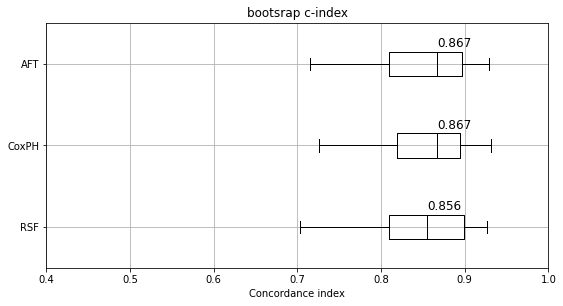

In [49]:
df = pd.DataFrame([C_Idx_test, C_Idx_test2,C_Idx_test3], index=['AFT', 'CoxPH', 'RSF'])
df2 = df.transpose()

colors = ['#000000', '#000000', '#ff7f00']
colors_setosa = dict(color=colors[0])
colors_versicolor = dict(color=colors[1])
colors_versicolor2 = dict(color=colors[2])

aft_median = np.median(df2['AFT'])
cox_median = np.median(df2['CoxPH'])
rsf_median = np.median(df2['RSF'])
aft_std = np.std(df2['AFT'])
cox_std = np.std(df2['CoxPH'])
rsf_std = np.std(df2['RSF'])

fig, ax = plt.subplots(figsize=(9,4.5))
ax = df2.boxplot(column=[ 'RSF', 'CoxPH', 'AFT'], vert=False, color = 'k')
plt.annotate(str(np.round(aft_median,3)), xy=(aft_median, 0.8)
                , xytext=(aft_median, 3.205) , fontsize=12)
plt.annotate(str(np.round(cox_median,3)), xy=(aft_median, 0.8)
                , xytext=(cox_median, 2.205) , fontsize=12)
plt.annotate(str(np.round(rsf_median,3)), xy=(aft_median, 0.8)
                , xytext=(rsf_median, 1.205) , fontsize=12)
plt.xlim([0.4,1.0])
plt.xlabel('Concordance index')
plt.title('bootsrap c-index')
plt.show()

###(3) D-calibration

In [29]:
def d_calibration_table(model, data, feature_list):
  global bin_cs
  df_occurred = data.query('status_opt == 1')
  df_censored = data.query('status_opt == 0')
  calibration = pd.DataFrame(np.zeros((2, 10)))
  calibration.index = ['Occurred', 'Censored']
  calibration.columns = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
  
  if model == rsf:
    for i in range(len(df_occurred)):
      result = np.squeeze(model.predict_survival_function(df_occurred[feature_list].iloc[i, :].to_numpy().reshape(1, -1), return_array = True))
      time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })
      probability = time_result.iloc[(time_result['time']-df_occurred.iloc[i, :]['time_opt']).abs().argsort()[:1]].iloc[0,1]
      bin = math.floor(probability*10)*10
      calibration.loc['Occurred'][bin] = calibration.loc['Occurred'][bin]+1

    for j in range(len(df_censored)):
      result_cs = np.squeeze(model.predict_survival_function(df_censored[feature_list].iloc[j, :].to_numpy().reshape(1, -1), return_array = True))
      time_result_cs = pd.DataFrame({'time' : rsf.event_times_, 'p' : result_cs })
      probability_cs = time_result_cs.iloc[(time_result_cs['time']-df_censored.iloc[j, :]['time_opt']).abs().argsort()[:1]].iloc[0,1]
      if probability_cs == 1:
        bins_cs = 90
      else :
        bin_cs = math.floor(probability_cs*10)*10
      calibration.loc['Censored'][bin_cs] = calibration.loc['Censored'][bin_cs]+(1-(0.01*bin_cs/probability_cs))

      for k in range(0,bin_cs,10):
        calibration.loc['Censored'][k] = calibration.loc['Censored'][k]+(0.1/probability_cs)

  else :
    for i in range(len(df_occurred)):
      pred_curve = model.predict_survival_function(df_occurred[feature_list].iloc[i, :]).reset_index()
      probability = pred_curve.iloc[(pred_curve['index']-df_occurred.iloc[i, :]['time_opt']).abs().argsort()[:1]].iloc[0,1]
      bin = math.floor(probability*10)*10
      calibration.loc['Occurred'][bin] = calibration.loc['Occurred'][bin]+1

    for j in range(len(df_censored)):
      pred_curve_cs = model.predict_survival_function(df_censored[feature_list].iloc[j, :]).reset_index()
      probability_cs = pred_curve_cs.iloc[(pred_curve_cs['index']-df_censored.iloc[j, :]['time_opt']).abs().argsort()[:1]].iloc[0,1] 
      if probability_cs == 1:
        bins_cs = 90
      else :
        bin_cs = math.floor(probability_cs*10)*10
      calibration.loc['Censored'][bin_cs] = calibration.loc['Censored'][bin_cs]+(1-(0.01*bin_cs/probability_cs))

      for k in range(0,bin_cs,10):
        calibration.loc['Censored'][k] = calibration.loc['Censored'][k]+(0.1/probability_cs)

  calibration = np.transpose(calibration)
  calibration['Total'] = calibration['Occurred'] + calibration['Censored']
  quantile_list = ['[0%-10%)','[10%-20%)','[20%-30%)','[30%-40%)','[40%-50%)','[50%-60%)','[60%-70%)','[70%-80%)','[80%-90%)','[90%-100%]']
  calibration.index = quantile_list
  return calibration

cph_d_cal_full_result = d_calibration_table(cph, df_full_slope_imputed, cph_feature_list)
aft_d_cal_full_result = d_calibration_table(aft, df_full_slope_imputed, aft_feature_list)
rsf_d_cal_full_result = d_calibration_table(rsf, df_full_slope_imputed, rsf_feature_list)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature n

Chi-square goodness of fit test : check uniformity

In [30]:
def chi_test(table, data):
  chi_df = (table/len(data)*100)[['Total']]
  chi_df['exp'] = 10
  chi_df.columns = ['obs', 'exp']
  chi_df = np.transpose(chi_df)
  chi_result = chisquare(np.array(chi_df.loc['obs']))
  
  return chi_result

In [31]:
from scipy.stats import chisquare

In [32]:
n_iterations = 20  #No. of bootstrap samples to be repeated (created)
n_size = int(len(df_full_slope_imputed) * 0.50) #Size of sample, picking only 50% of the given data in every bootstrap sample

Chi_stats_aft = np.array([])
Chi_stats_cph = np.array([])
Chi_stats_rsf = np.array([])
p_val_aft = np.array([])
p_val_cph = np.array([])
p_val_rsf = np.array([])

for i in range(n_iterations):

    test = resample(df_full_slope_imputed, n_samples = n_size, random_state = 10*i)

    chi_cph = chi_test(d_calibration_table(cph, test, cph_feature_list), test)
    chi_aft = chi_test(d_calibration_table(aft, test, aft_feature_list), test)

    arr_rsf = list(tuple(x) for x in test[['status_opt', 'time_opt']].replace({'status_opt':dic}).to_records(index=False))
    test_y_rsf = np.array(arr_rsf, dtype=dt)
    test_y_rsf.dtype.names=['cens', 'time']
    chi_rsf = chi_test(d_calibration_table(rsf, test, rsf_feature_list), test)

    Chi_stats_aft = np.append (Chi_stats_aft, chi_aft[0])
    Chi_stats_cph = np.append (Chi_stats_cph, chi_cph[0])
    Chi_stats_rsf = np.append (Chi_stats_rsf, chi_rsf[0]) 
    p_val_aft = np.append (p_val_rsf, chi_aft[1])
    p_val_cph = np.append (p_val_rsf, chi_cph[1])
    p_val_rsf = np.append (p_val_rsf, chi_rsf[1])
print(len(Chi_stats_aft))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature n

20


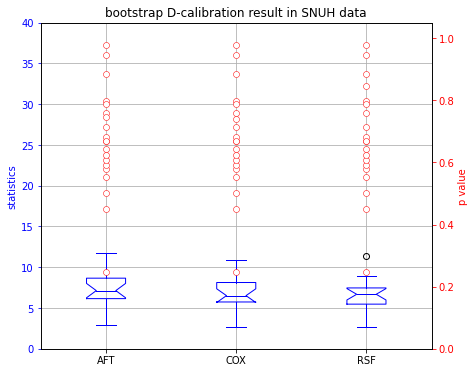

In [33]:
stats = pd.DataFrame([Chi_stats_aft, Chi_stats_cph, Chi_stats_rsf], index=['AFT', 'COX','RSF']).transpose()

p_aft =pd.DataFrame([p_val_aft], index=['significance']).transpose()
p_aft['model']=1
p_cph =pd.DataFrame([p_val_cph], index=['significance']).transpose()
p_cph['model']=2
p_rsf =pd.DataFrame([p_val_rsf], index=['significance']).transpose()
p_rsf['model']=3

fig, ax = plt.subplots(figsize=(7,6))
ax= stats.boxplot(column=['AFT','COX','RSF'], color = 'b', notch=True)
ax2 = ax.twinx()
ax2.scatter(x="model", y='significance',  data=p_aft, color='w', edgecolor='r', linewidths=0.5)
ax2.scatter(x="model", y='significance',  data=p_cph, color='w', edgecolor='r', linewidths=0.5)
ax2.scatter(x="model", y='significance',  data=p_rsf, color='w', edgecolor='r', linewidths=0.5)

ax2.set_ylim([0,1.05])
ax2.set_ylabel('p value', color='r')
[t.set_color('red') for t in ax2.yaxis.get_ticklines()]
[t.set_color('red') for t in ax2.yaxis.get_ticklabels()]
ax.set_ylim([0,40])
ax.set_ylabel('statistics', color='b')
[t.set_color('blue') for t in ax.yaxis.get_ticklines()]
[t.set_color('blue') for t in ax.yaxis.get_ticklabels()]
plt.title('bootstrap D-calibration result in SNUH data')
plt.show()

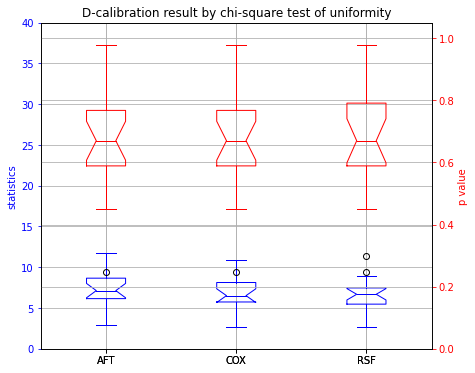

In [34]:
stats = pd.DataFrame([Chi_stats_aft, Chi_stats_cph, Chi_stats_rsf], index=['AFT', 'COX','RSF']).transpose()
p = pd.DataFrame([p_val_aft, p_val_cph, p_val_rsf], index=['AFT', 'COX','RSF']).transpose()

fig, ax = plt.subplots(figsize=(7,6))
ax= stats.boxplot(column=['AFT','COX','RSF'], color = 'b', notch=True)
ax2 = ax.twinx()
ax2 = p.boxplot(column=['AFT','COX','RSF'], color = 'r', notch=True)

ax2.set_ylim([0,1.05])
ax2.set_ylabel('p value', color='r')
[t.set_color('red') for t in ax2.yaxis.get_ticklines()]
[t.set_color('red') for t in ax2.yaxis.get_ticklabels()]
ax.set_ylim([0,40])
ax.set_ylabel('statistics', color='b')
[t.set_color('blue') for t in ax.yaxis.get_ticklines()]
[t.set_color('blue') for t in ax.yaxis.get_ticklabels()]
plt.title('D-calibration result by chi-square test of uniformity')
plt.show()

### (4) Integrated Brier score

In [35]:
from sklearn.model_selection import train_test_split
from sksurv.functions import StepFunction
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import integrated_brier_score
from sksurv.nonparametric import kaplan_meier_estimator

In [36]:
y = y_train_rsf

dic = {1:True, 0:False}
dt = np.dtype('bool, float')

y_snuh = df_full_slope_imputed[['status_opt', 'time_opt']].replace({'status_opt':dic})
y_snuh = np.array(list(tuple(x) for x in y_snuh.to_records(index=False)), dtype = dt)
y_snuh.dtype.names=['cens', 'time']

Text(0.5, 1.0, 'snuh_time')

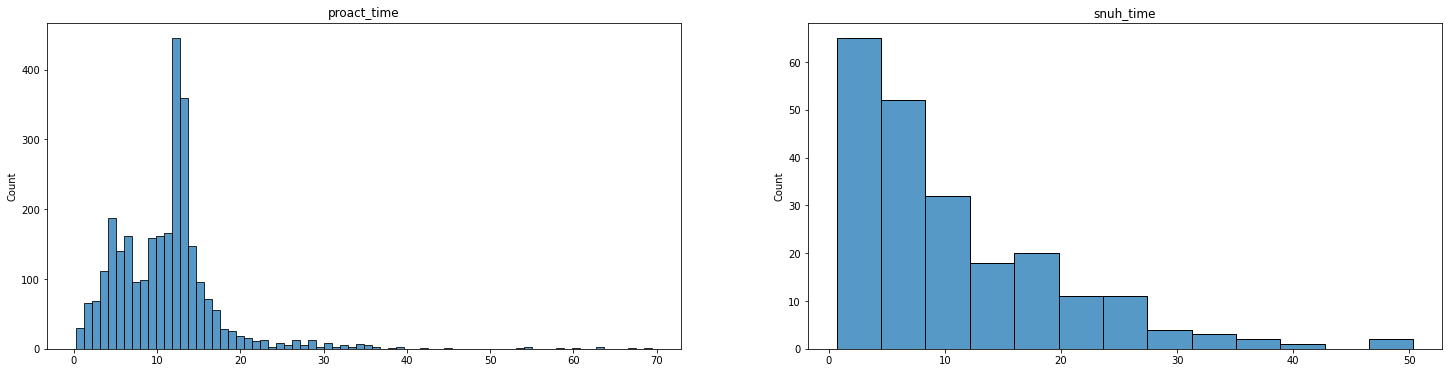

In [37]:
plt.figure(figsize=(25, 6))
plt.subplot(121)
sns.histplot(y['time'])
plt.title('proact_time')

plt.subplot(122)
sns.histplot(y_snuh['time'])
plt.title('snuh_time')

#### test with whole snuh data

In [38]:
# time range of (1~30) is used
lower, upper = 1, 30
times = np.arange(lower, upper, 0.01)
print('time range :', lower, upper)

aft_predicted = aft.predict_survival_function(df_full_slope_imputed[aft_feature_list]).transpose()
aft_surv_prob = np.row_stack([
    StepFunction(
        np.array(aft_predicted.columns), np.array(aft_predicted.iloc[i,:])
    )(times) 
    for i in range(len(aft_predicted))
])
print('AFT ibs :', integrated_brier_score(y, y_snuh, aft_surv_prob, times))

cph_predicted = cph.predict_survival_function(df_full_slope_imputed[cph_feature_list]).transpose()
cph_surv_prob = np.row_stack([
    StepFunction(
        np.array(cph_predicted.columns), np.array(cph_predicted.iloc[i,:])
    )(times) 
    for i in range(len(cph_predicted))
])
print('COX ibs :', integrated_brier_score(y, y_snuh, cph_surv_prob, times))

rsf_predicted = pd.DataFrame(data = rsf.predict_survival_function(df_full_slope_imputed[rsf_feature_list], return_array = True),
             columns = rsf.event_times_)
rsf_surv_prob = np.row_stack([
    StepFunction(
        np.array(rsf_predicted.columns), np.array(rsf_predicted.iloc[i,:])
    )(times) 
    for i in range(len(rsf_predicted))
])
print('RSF ibs :', integrated_brier_score(y, y_snuh, rsf_surv_prob, times))

km_func = StepFunction(
    *kaplan_meier_estimator(y_snuh["cens"], y_snuh["time"])
  )
km_surv_prob = np.tile(km_func(times), (y_snuh.shape[0], 1))
print('KM ibs :', integrated_brier_score(y, y_snuh, km_surv_prob, times))

random_surv_prob = 0.5 * np.ones(
    (y_snuh.shape[0], times.shape[0])
  )
print('random ibs :', integrated_brier_score(y, y_snuh, random_surv_prob, times))

time range : 1 30
AFT ibs : 0.18455003248509344
COX ibs : 0.17686504024131205
RSF ibs : 0.1884017017596709
KM ibs : 0.1663948342867657
random ibs : 0.3336299048814514


### (5) Demonstrations

In [39]:
df_full_slope_imputed[['status_opt','time_opt']].iloc[10:15, :]

,status_opt,time_opt
10,0,26.235616
11,1,24.591781
12,1,23.704110
13,0,4.076712
14,1,4.372603


Text(0.5, 1.0, 'AFT')

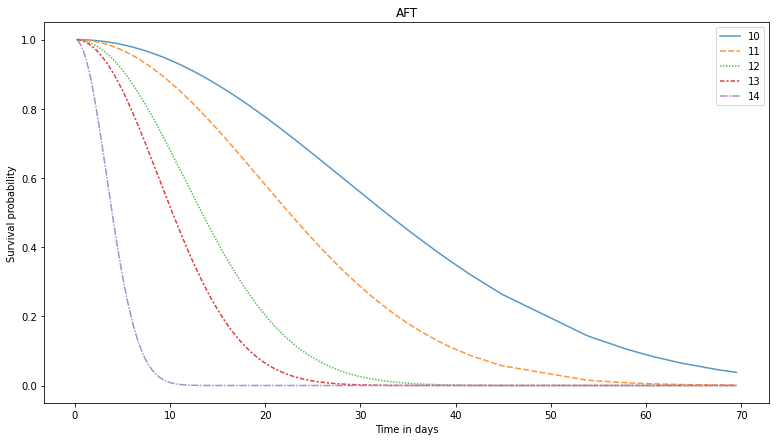

In [40]:
palette = {10:'#5698C6', 11:'#FF9539',   12:'#60B760',   13:'#DB4142',  14: "#AE8CCD"}

fig, ax = plt.subplots(figsize=(13,7))
result_aft = aft.predict_survival_function(df_full_slope_imputed[aft_feature_list+['status_opt', 'time_opt']].iloc[10:15, :])
ax = sns.lineplot(data = result_aft, palette= palette)
ax.set(xlabel='Time in days', ylabel='Survival probability')
ax.set_title("AFT")

Text(0.5, 1.0, 'COXPH')

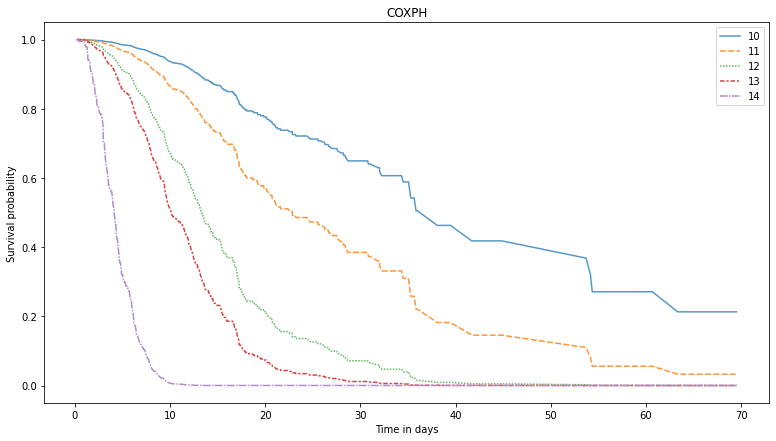

In [41]:
fig, ax = plt.subplots(figsize=(13,7))
result_cph = cph.predict_survival_function(df_full_slope_imputed[cph_feature_list+['status_opt', 'time_opt']].iloc[10:15, :])
ax = sns.lineplot(data = result_cph, palette= palette)
ax.set(xlabel='Time in days', ylabel='Survival probability')
ax.set_title("COXPH")

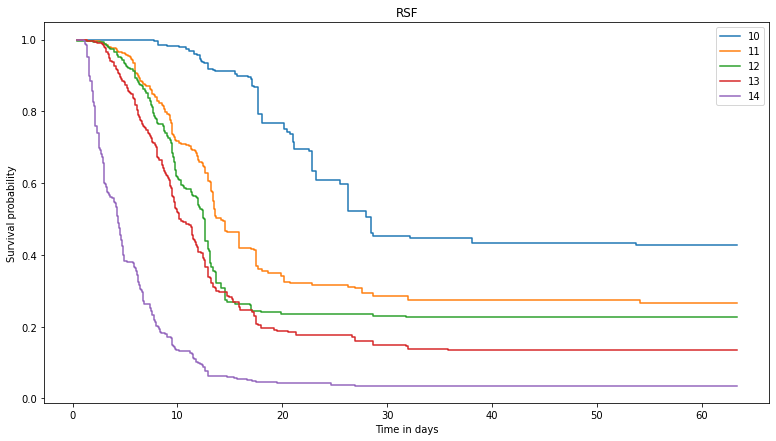

In [42]:
result_rsf = rsf.predict_survival_function(df_full_slope_imputed[rsf_feature_list].iloc[10:15, :], return_array=True)
fig, ax = plt.subplots(figsize=(13,7))
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post")
    
plt.legend(labels = list(df_full_slope_imputed[rsf_feature_list].iloc[10:15, :].index))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.title("RSF")
plt.show()